# Toxic Comment Classification – (CW2)

In [1]:
import sys
print(sys.executable)

d:\UsersFolder\Desktop\3. Artificial Intiligence\cw2-ai-toxic-comment-classification\venv\Scripts\python.exe


In [2]:
#Basic imports

import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report, f1_score, confusion_matrix,
    roc_curve, auc, roc_auc_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
import pyarrow
print(pyarrow.__version__)


23.0.0


In [4]:
import os
print(os.getcwd())
print(os.listdir())


d:\UsersFolder\Desktop\3. Artificial Intiligence\cw2-ai-toxic-comment-classification\notebooks
['toxic_comment_model.ipynb']


## 1) Load Dataset

In [5]:
df = pd.read_parquet("../dataset/train.parquet")
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
print("Shape:", df.shape)

Shape: (159571, 7)


## 2) Set Text Column + Label Columns

In [7]:
print("Columns:\n", df.columns.tolist())


Columns:
 ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [8]:
# Try common text column names
possible_text_cols = ["comment_text", "text", "comment", "content", "sentence"]

TEXT_COL = None
for c in possible_text_cols:
    if c in df.columns:
        TEXT_COL = c
        break

if TEXT_COL is None:
    # fallback: first column
    TEXT_COL = df.columns[0]

LABEL_COLS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

missing_labels = [c for c in LABEL_COLS if c not in df.columns]
print("TEXT_COL:", TEXT_COL)
print("Missing label cols:", missing_labels)

if missing_labels:
    raise ValueError(f"Your dataset is missing these label columns: {missing_labels}")


TEXT_COL: comment_text
Missing label cols: []


## 3) Basic Cleaning + Text Preprocessing


In [9]:
df[TEXT_COL] = df[TEXT_COL].fillna("").astype(str)

for c in LABEL_COLS:
    df[c] = df[c].fillna(0).astype(int)

print("Missing text:", df[TEXT_COL].isna().sum())
print("Missing labels:", df[LABEL_COLS].isna().sum().sum())


Missing text: 0
Missing labels: 0


In [10]:
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\S+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean_text"] = df[TEXT_COL].apply(clean_text)
df[["clean_text"]].head()


,clean_text
0,explanation why the edits made under my userna...
1,d aww he matches this background colour i m se...
2,hey man i m really not trying to edit war it s...
3,more i can t make any real suggestions on impr...
4,you sir are my hero any chance you remember wh...


## 4) EDA: Label Distribution


In [11]:
label_counts = df[LABEL_COLS].sum().sort_values(ascending=False)
label_counts


toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

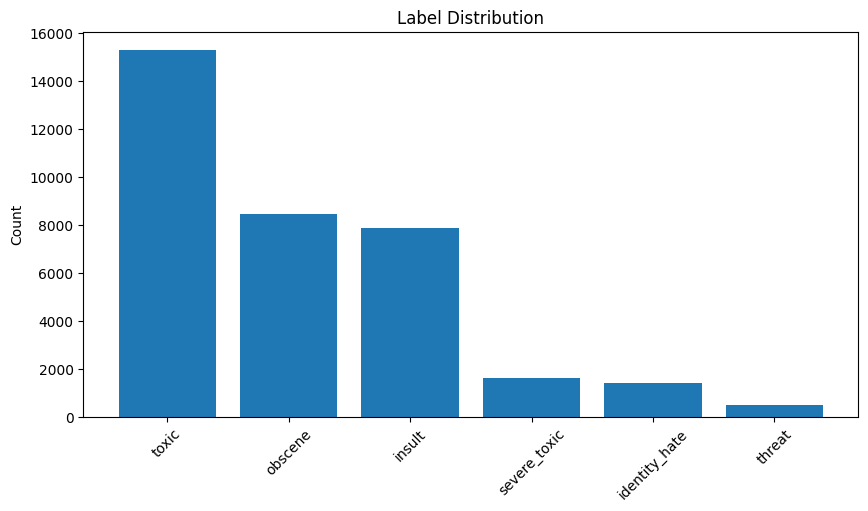

In [12]:
plt.figure(figsize=(10,5))
plt.bar(label_counts.index, label_counts.values)
plt.title("Label Distribution")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


## 5) Train-Test Split


In [13]:
X = df["clean_text"]
y = df[LABEL_COLS].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (127656,) (127656, 6)
Test: (31915,) (31915, 6)


## 6) TF-IDF Vectorization

In [14]:
tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TFIDF Train:", X_train_tfidf.shape)
print("TFIDF Test:", X_test_tfidf.shape)


TFIDF Train: (127656, 30000)
TFIDF Test: (31915, 30000)


## 7) Model 1: Multinomial Naive Bayes (Training)

In [15]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

nb_model = OneVsRestClassifier(MultinomialNB())
nb_model.fit(X_train_tfidf, y_train)

print("Naive Bayes model trained successfully.")


Naive Bayes model trained successfully.


## 7.1) Naive Bayes: Prediction + Performance Metrics


In [16]:
from sklearn.metrics import f1_score, classification_report

# Predict labels
nb_pred = nb_model.predict(X_test_tfidf)

# F1 scores
nb_f1_micro = f1_score(y_test, nb_pred, average="micro")
nb_f1_macro = f1_score(y_test, nb_pred, average="macro")

print("Naive Bayes F1 Micro:", round(nb_f1_micro, 4))
print("Naive Bayes F1 Macro:", round(nb_f1_macro, 4))

print("\nClassification Report (Naive Bayes):\n")
print(classification_report(y_test, nb_pred, target_names=LABEL_COLS, zero_division=0))


Naive Bayes F1 Micro: 0.5918
Naive Bayes F1 Macro: 0.3463

Classification Report (Naive Bayes):

               precision    recall  f1-score   support

        toxic       0.89      0.53      0.66      3056
 severe_toxic       0.68      0.11      0.19       321
      obscene       0.90      0.49      0.64      1715
       threat       0.00      0.00      0.00        74
       insult       0.82      0.42      0.56      1614
identity_hate       0.50      0.02      0.03       294

    micro avg       0.87      0.45      0.59      7074
    macro avg       0.63      0.26      0.35      7074
 weighted avg       0.84      0.45      0.58      7074
  samples avg       0.05      0.04      0.04      7074



## 7.2) Naive Bayes: Confusion Matrices (Per Label)


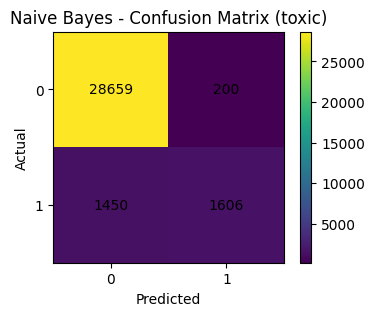

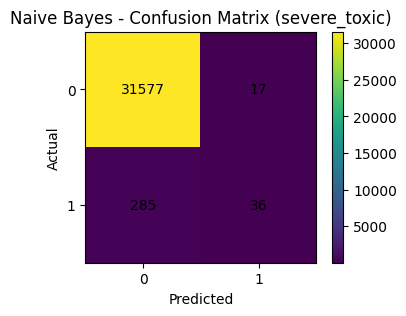

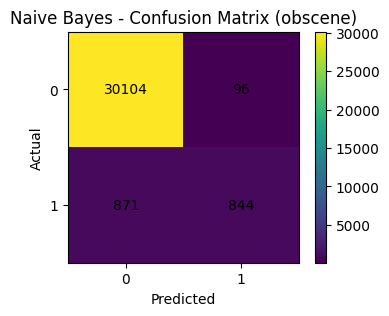

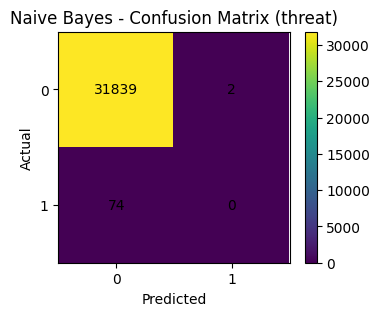

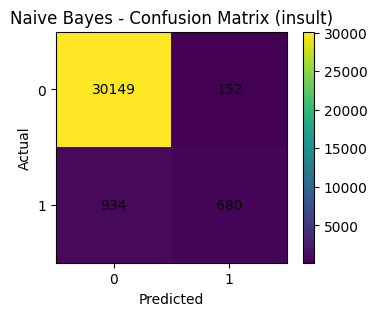

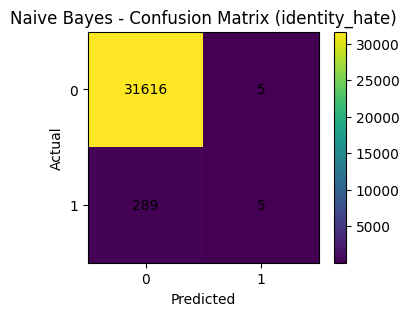

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

for i, label in enumerate(LABEL_COLS):
    cm = confusion_matrix(y_test[:, i], nb_pred[:, i])

    plt.figure(figsize=(4,3))
    plt.imshow(cm)
    plt.title(f"Naive Bayes - Confusion Matrix ({label})")
    plt.xticks([0,1], ["0","1"])
    plt.yticks([0,1], ["0","1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    for (r, c), v in np.ndenumerate(cm):
        plt.text(c, r, str(v), ha="center", va="center")

    plt.colorbar()
    plt.show()


## 7.3) Naive Bayes: ROC Curve and AUC (Multi-Label)


In [18]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

nb_probs = nb_model.predict_proba(X_test_tfidf)

# Convert probs into (n_samples, n_labels) matrix safely
if isinstance(nb_probs, list):
    # list of arrays (one per label)
    nb_prob = np.column_stack([p[:, 1] for p in nb_probs])
else:
    # already a matrix
    nb_probs = np.array(nb_probs)

    # If it's (n_samples, 2) -> single label case
    if nb_probs.ndim == 2 and nb_probs.shape[1] == 2:
        nb_prob = nb_probs[:, 1].reshape(-1, 1)
    else:
        nb_prob = nb_probs


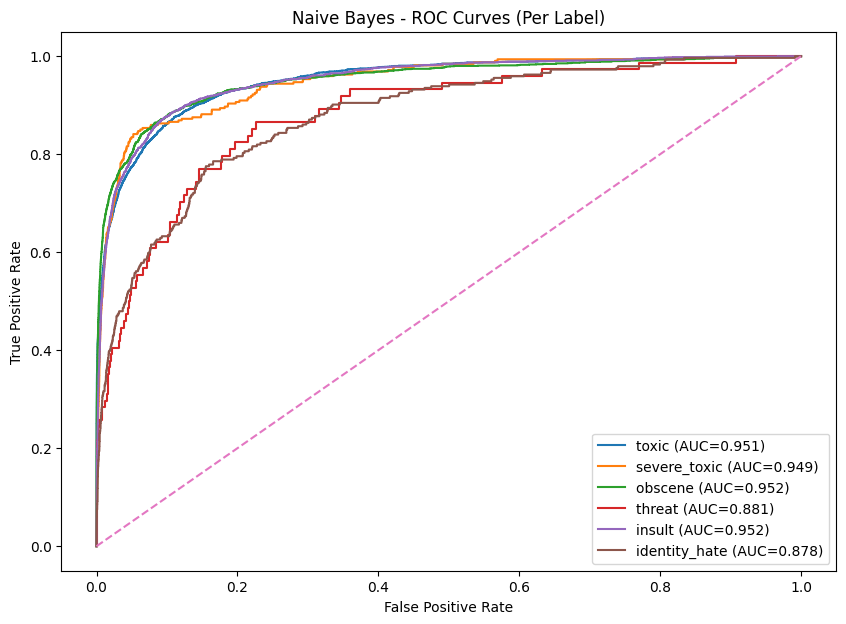

In [19]:
plt.figure(figsize=(10,7))

for i, label in enumerate(LABEL_COLS):
    if len(np.unique(y_test[:, i])) < 2:
        continue

    fpr, tpr, _ = roc_curve(y_test[:, i], nb_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle="--")
plt.title("Naive Bayes - ROC Curves (Per Label)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [20]:
nb_micro_auc = roc_auc_score(y_test, nb_prob, average="micro")
nb_macro_auc = roc_auc_score(y_test, nb_prob, average="macro")

print("Naive Bayes ROC-AUC Micro:", round(nb_micro_auc, 4))
print("Naive Bayes ROC-AUC Macro:", round(nb_macro_auc, 4))


Naive Bayes ROC-AUC Micro: 0.9546
Naive Bayes ROC-AUC Macro: 0.9269


## 8) Model 2: Logistic Regression (Training)


In [21]:
from sklearn.linear_model import LogisticRegression

lr_model = OneVsRestClassifier(LogisticRegression(max_iter=2000))
lr_model.fit(X_train_tfidf, y_train)

print("Logistic Regression model trained successfully.")


Logistic Regression model trained successfully.


## 8.1) Logistic Regression: Prediction + Performance Metrics


In [22]:
lr_pred = lr_model.predict(X_test_tfidf)

lr_f1_micro = f1_score(y_test, lr_pred, average="micro")
lr_f1_macro = f1_score(y_test, lr_pred, average="macro")

print("Logistic Regression F1 Micro:", round(lr_f1_micro, 4))
print("Logistic Regression F1 Macro:", round(lr_f1_macro, 4))

print("\nClassification Report (Logistic Regression):\n")
print(classification_report(y_test, lr_pred, target_names=LABEL_COLS, zero_division=0))


Logistic Regression F1 Micro: 0.668
Logistic Regression F1 Macro: 0.4684

Classification Report (Logistic Regression):

               precision    recall  f1-score   support

        toxic       0.92      0.60      0.72      3056
 severe_toxic       0.60      0.23      0.33       321
      obscene       0.93      0.59      0.72      1715
       threat       0.88      0.09      0.17        74
       insult       0.85      0.50      0.63      1614
identity_hate       0.75      0.14      0.23       294

    micro avg       0.90      0.53      0.67      7074
    macro avg       0.82      0.36      0.47      7074
 weighted avg       0.88      0.53      0.66      7074
  samples avg       0.05      0.05      0.05      7074



## 8.2) Logistic Regression: Confusion Matrices (Per Label)


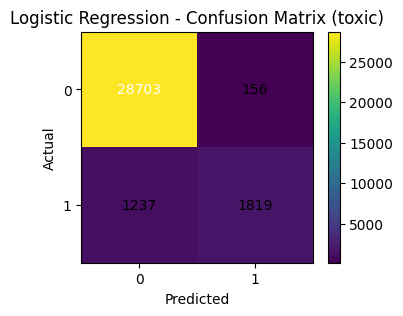

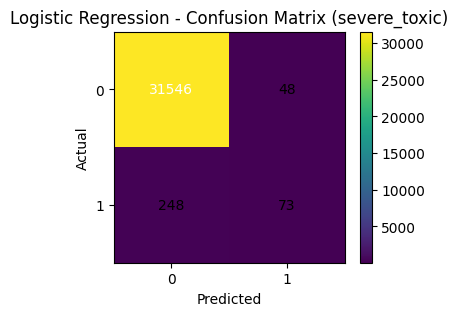

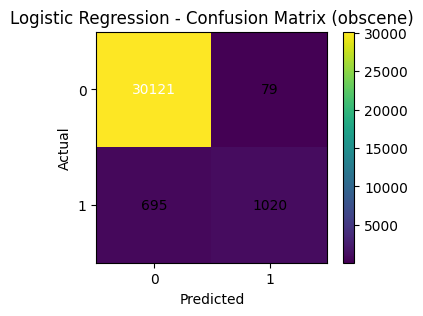

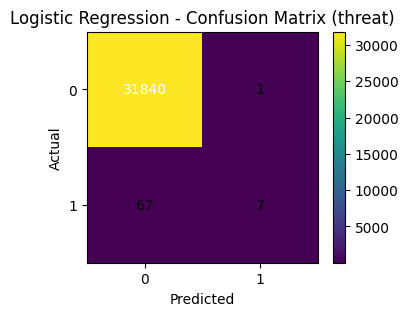

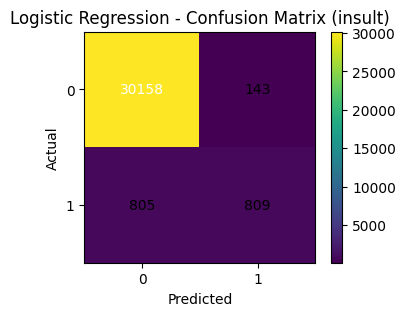

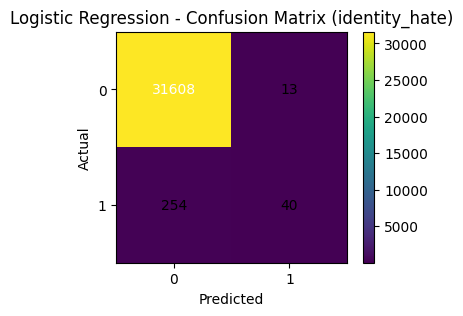

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

for i, label in enumerate(LABEL_COLS):
    cm = confusion_matrix(y_test[:, i], lr_pred[:, i])

    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Logistic Regression - Confusion Matrix ({label})")
    plt.colorbar()
    plt.xticks([0,1], ["0","1"])
    plt.yticks([0,1], ["0","1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Add numbers inside each cell
    for (r, c), v in np.ndenumerate(cm):
        plt.text(c, r, str(v), ha="center", va="center", color="white" if v > cm.max()/2 else "black")

    plt.show()


## 8.3) Logistic Regression: ROC Curve and AUC (Multi-Label)


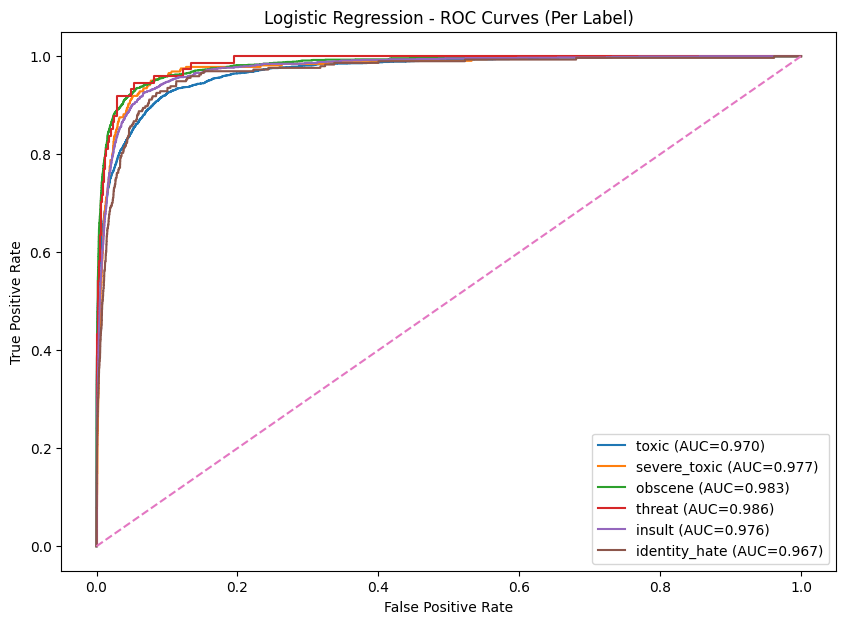

In [24]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

lr_probs = lr_model.predict_proba(X_test_tfidf)

# safe conversion
if isinstance(lr_probs, list):
    lr_prob = np.column_stack([p[:, 1] for p in lr_probs])
else:
    lr_prob = np.array(lr_probs)

plt.figure(figsize=(10,7))
for i, label in enumerate(LABEL_COLS):
    if len(np.unique(y_test[:, i])) < 2:
        continue

    fpr, tpr, _ = roc_curve(y_test[:, i], lr_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.title("Logistic Regression - ROC Curves (Per Label)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



In [25]:
lr_micro_auc = roc_auc_score(y_test, lr_prob, average="micro")
lr_macro_auc = roc_auc_score(y_test, lr_prob, average="macro")

print("Logistic Regression ROC-AUC Micro:", round(lr_micro_auc, 4))
print("Logistic Regression ROC-AUC Macro:", round(lr_macro_auc, 4))


Logistic Regression ROC-AUC Micro: 0.9805
Logistic Regression ROC-AUC Macro: 0.9767


## 9) Model 3: Random Forest (Training)


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_model = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=150,
        max_depth=30,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
)

rf_model.fit(X_train_tfidf, y_train)
print("Random Forest model trained successfully.")

Random Forest model trained successfully.


## 9.1) Random Forest: Prediction + Performance Metrics


In [27]:
rf_pred = rf_model.predict(X_test_tfidf)

rf_f1_micro = f1_score(y_test, rf_pred, average="micro")
rf_f1_macro = f1_score(y_test, rf_pred, average="macro")

print("Random Forest F1 Micro:", round(rf_f1_micro, 4))
print("Random Forest F1 Macro:", round(rf_f1_macro, 4))

print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, rf_pred, target_names=LABEL_COLS, zero_division=0))


Random Forest F1 Micro: 0.1586
Random Forest F1 Macro: 0.0865

Classification Report (Random Forest):

               precision    recall  f1-score   support

        toxic       1.00      0.10      0.19      3056
 severe_toxic       1.00      0.01      0.01       321
      obscene       0.99      0.11      0.21      1715
       threat       0.00      0.00      0.00        74
       insult       0.93      0.06      0.12      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.98      0.09      0.16      7074
    macro avg       0.65      0.05      0.09      7074
 weighted avg       0.93      0.09      0.16      7074
  samples avg       0.01      0.01      0.01      7074



## 9.2) Random Forest: Confusion Matrices (Per Label)


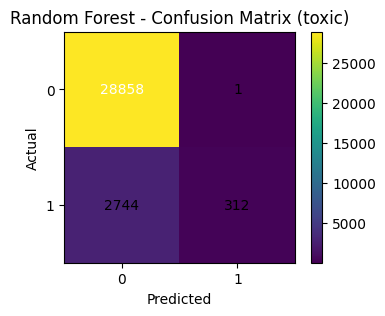

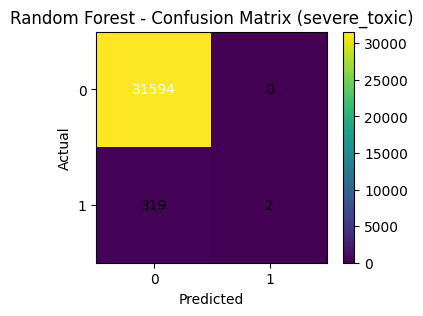

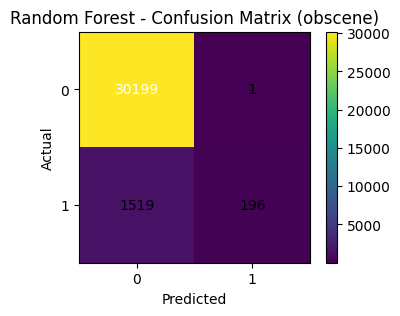

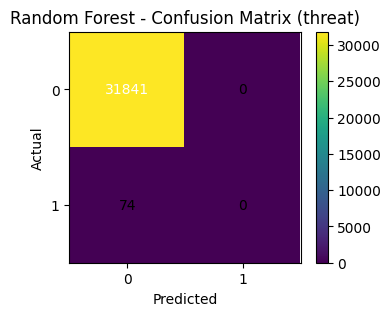

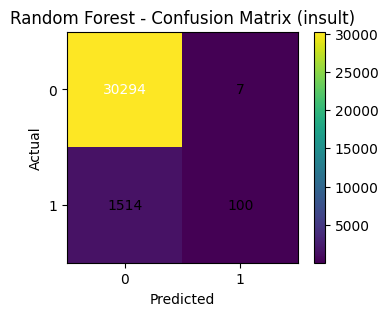

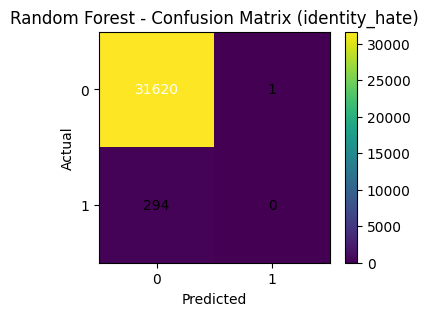

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

for i, label in enumerate(LABEL_COLS):
    cm = confusion_matrix(y_test[:, i], rf_pred[:, i])

    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Random Forest - Confusion Matrix ({label})")
    plt.colorbar()
    plt.xticks([0,1], ["0","1"])
    plt.yticks([0,1], ["0","1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Add numbers inside each cell
    for (r, c), v in np.ndenumerate(cm):
        plt.text(
            c, r, str(v),
            ha="center", va="center",
            color="white" if v > cm.max()/2 else "black"
        )

    plt.show()


## 9.3) Random Forest: ROC Curve and AUC (Multi-Label)


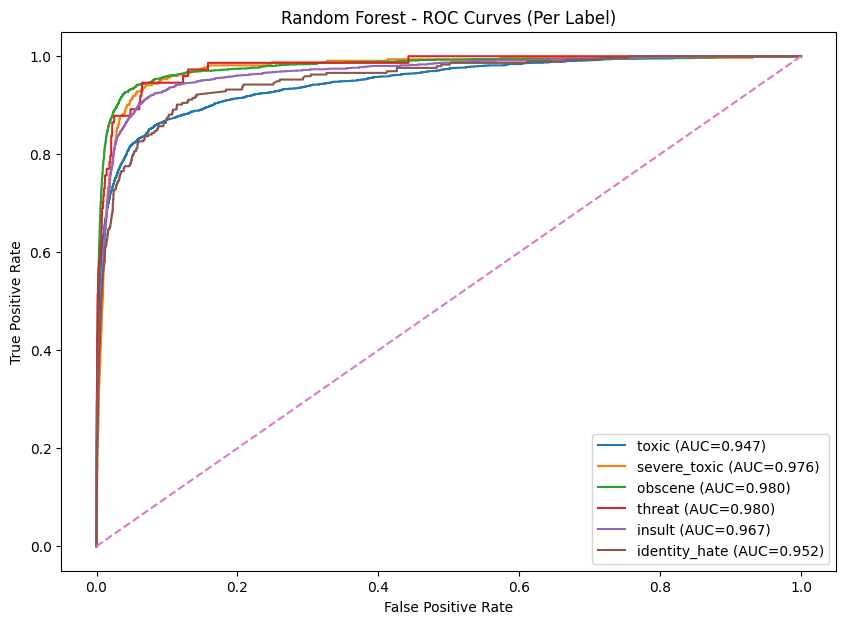

Random Forest ROC-AUC Micro: 0.9637
Random Forest ROC-AUC Macro: 0.9669


In [29]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

rf_probs = rf_model.predict_proba(X_test_tfidf)

# safe conversion to (n_samples, n_labels)
if isinstance(rf_probs, list):
    rf_prob = np.column_stack([p[:, 1] for p in rf_probs])
else:
    rf_prob = np.array(rf_probs)

plt.figure(figsize=(10,7))
for i, label in enumerate(LABEL_COLS):
    if len(np.unique(y_test[:, i])) < 2:
        continue

    fpr, tpr, _ = roc_curve(y_test[:, i], rf_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.title("Random Forest - ROC Curves (Per Label)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

rf_micro_auc = roc_auc_score(y_test, rf_prob, average="micro")
rf_macro_auc = roc_auc_score(y_test, rf_prob, average="macro")

print("Random Forest ROC-AUC Micro:", round(rf_micro_auc, 4))
print("Random Forest ROC-AUC Macro:", round(rf_macro_auc, 4))


## 10) Model Comparison (All 3 Models)


In [30]:
comparison_df = pd.DataFrame([
    ["Naive Bayes", nb_f1_micro, nb_f1_macro, nb_micro_auc, nb_macro_auc],
    ["Logistic Regression", lr_f1_micro, lr_f1_macro, lr_micro_auc, lr_macro_auc],
    ["Random Forest", rf_f1_micro, rf_f1_macro, rf_micro_auc, rf_macro_auc],
], columns=["Model", "F1 Micro", "F1 Macro", "ROC-AUC Micro", "ROC-AUC Macro"])

comparison_df.sort_values(by="F1 Micro", ascending=False)


,Model,F1 Micro,F1 Macro,ROC-AUC Micro,ROC-AUC Macro
1,Logistic Regression,0.667967,0.468369,0.980454,0.976651
0,Naive Bayes,0.591770,0.346305,0.954624,0.926880
2,Random Forest,0.158565,0.086472,0.963710,0.966931


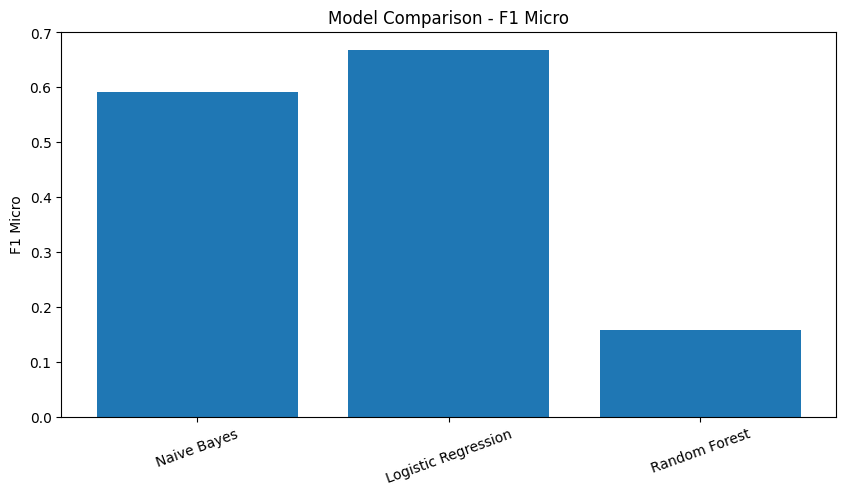

In [31]:
plt.figure(figsize=(10,5))
plt.bar(comparison_df["Model"], comparison_df["F1 Micro"])
plt.title("Model Comparison - F1 Micro")
plt.ylabel("F1 Micro")
plt.xticks(rotation=20)
plt.show()


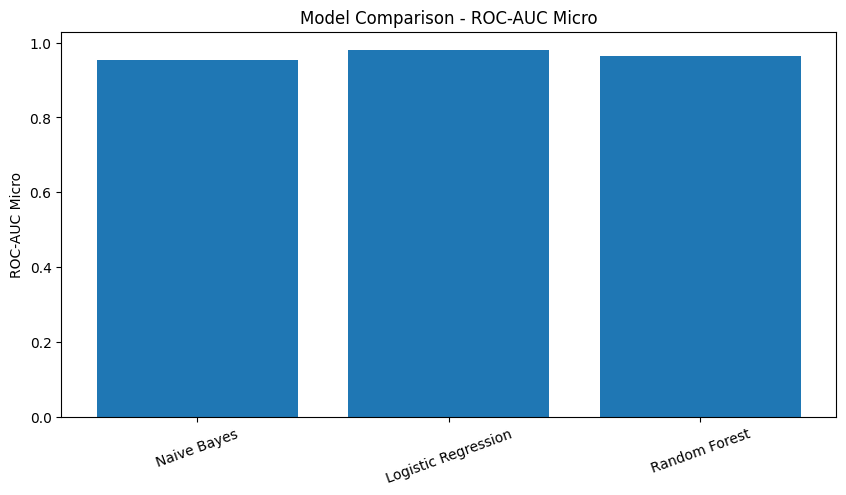

In [32]:
plt.figure(figsize=(10,5))
plt.bar(comparison_df["Model"], comparison_df["ROC-AUC Micro"])
plt.title("Model Comparison - ROC-AUC Micro")
plt.ylabel("ROC-AUC Micro")
plt.xticks(rotation=20)
plt.show()


## 11) Application Demo (User Input → All 3 Models Results)


In [33]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

def get_label_probs(model, X_vec, label_cols):
    probs = model.predict_proba(X_vec)

    if isinstance(probs, list):
        return np.array([p[0, 1] for p in probs])

    probs = np.array(probs)
    if probs.ndim == 2 and probs.shape[1] == len(label_cols):
        return probs[0]

    raise ValueError(f"Unexpected predict_proba shape: {probs.shape}")

# UI elements
text_box = widgets.Textarea(
    value="",
    placeholder="Type a comment here...",
    description="Comment:",
    layout=widgets.Layout(width="100%", height="80px")
)

btn = widgets.Button(description="Predict", button_style="success")
out = widgets.Output()

def on_predict_clicked(b):
    with out:
        clear_output()

        user_text = text_box.value.strip()
        if not user_text:
            print(" Please type a comment first.")
            return

        user_clean = clean_text(user_text)
        user_vec = tfidf.transform([user_clean])

        nb_probs = get_label_probs(nb_model, user_vec, LABEL_COLS)
        lr_probs = get_label_probs(lr_model, user_vec, LABEL_COLS)
        rf_probs = get_label_probs(rf_model, user_vec, LABEL_COLS)

        nb_preds = (nb_probs >= 0.5).astype(int)
        lr_preds = (lr_probs >= 0.5).astype(int)
        rf_preds = (rf_probs >= 0.5).astype(int)

        demo_table = pd.DataFrame({
            "Label": LABEL_COLS,
            "NB_Pred": nb_preds,
            "NB_Prob": np.round(nb_probs, 4),
            "LR_Pred": lr_preds,
            "LR_Prob": np.round(lr_probs, 4),
            "RF_Pred": rf_preds,
            "RF_Prob": np.round(rf_probs, 4),
        })

        print("User comment:", user_text)
        display(demo_table)

btn.on_click(on_predict_clicked)

display(text_box, btn, out)




Textarea(value='', description='Comment:', layout=Layout(height='80px', width='100%'), placeholder='Type a com…

Button(button_style='success', description='Predict', style=ButtonStyle())

Output()

## 12) Overfitting / Underfitting Check (Train vs Test F1)


In [35]:
from sklearn.metrics import f1_score
import numpy as np

def probs_to_matrix(model, X_vec, n_labels):
    probs = model.predict_proba(X_vec)

    # Case 1: list of arrays -> take positive class probability
    if isinstance(probs, list):
        return np.column_stack([p[:, 1] for p in probs])

    # Case 2: already a matrix
    probs = np.array(probs)

    # if (n_samples, n_labels)
    if probs.ndim == 2 and probs.shape[1] == n_labels:
        return probs

    raise ValueError(f"Unexpected predict_proba shape: {probs.shape}")

def train_test_f1_micro(model, X_train_vec, y_train, X_test_vec, y_test, label_cols, model_name):
    n_labels = len(label_cols)

    # Train prediction
    train_prob = probs_to_matrix(model, X_train_vec, n_labels)
    train_pred = (train_prob >= 0.5).astype(int)

    # Test prediction
    test_prob = probs_to_matrix(model, X_test_vec, n_labels)
    test_pred = (test_prob >= 0.5).astype(int)

    train_f1 = f1_score(y_train, train_pred, average="micro")
    test_f1 = f1_score(y_test, test_pred, average="micro")

    print(f"\n{model_name}")
    print("Train F1 Micro:", round(train_f1, 4))
    print("Test  F1 Micro:", round(test_f1, 4))
    print("Gap (Train - Test):", round(train_f1 - test_f1, 4))
    print("-" * 30)


In [36]:
train_test_f1_micro(nb_model, X_train_tfidf, y_train, X_test_tfidf, y_test, LABEL_COLS, "Naive Bayes")
train_test_f1_micro(lr_model, X_train_tfidf, y_train, X_test_tfidf, y_test, LABEL_COLS, "Logistic Regression")
train_test_f1_micro(rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, LABEL_COLS, "Random Forest")



Naive Bayes
Train F1 Micro: 0.6349
Test  F1 Micro: 0.5918
Gap (Train - Test): 0.0431
------------------------------

Logistic Regression
Train F1 Micro: 0.7074
Test  F1 Micro: 0.668
Gap (Train - Test): 0.0395
------------------------------

Random Forest
Train F1 Micro: 0.2343
Test  F1 Micro: 0.1586
Gap (Train - Test): 0.0757
------------------------------


## 13) Data Leakage Check


In [37]:
train_set = set(X_train)
test_set = set(X_test)

overlap = len(train_set.intersection(test_set))
print("Exact duplicate overlap between train and test:", overlap)


Exact duplicate overlap between train and test: 295


## 14) Threshold Optimization (Per Label) - Logistic Regression


In [38]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get LR probabilities on test set
lr_probs_test = lr_model.predict_proba(X_test_tfidf)

# Convert probs into (n_samples, n_labels) matrix safely
if isinstance(lr_probs_test, list):
    lr_prob_test = np.column_stack([p[:, 1] for p in lr_probs_test])
else:
    lr_prob_test = np.array(lr_probs_test)

print("LR prob matrix shape:", lr_prob_test.shape)  # should be (n_test, 6)

best_thresholds = {}

for i, label in enumerate(LABEL_COLS):
    precision, recall, thresholds = precision_recall_curve(y_test[:, i], lr_prob_test[:, i])

    f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
    best_idx = np.argmax(f1_scores)

    # thresholds length is usually 1 less than precision/recall length
    if best_idx >= len(thresholds):
        best_threshold = 0.5
    else:
        best_threshold = thresholds[best_idx]

    best_thresholds[label] = float(best_threshold)

best_thresholds


LR prob matrix shape: (31915, 6)


{'toxic': 0.27288145426777893,
 'severe_toxic': 0.1675248969347145,
 'obscene': 0.20251022357093992,
 'threat': 0.09788111893260865,
 'insult': 0.18090643977031684,
 'identity_hate': 0.11317540529548217}

In [39]:
from sklearn.metrics import classification_report, f1_score
import numpy as np

lr_tuned_pred = np.zeros_like(y_test)

for i, label in enumerate(LABEL_COLS):
    lr_tuned_pred[:, i] = (lr_prob_test[:, i] >= best_thresholds[label]).astype(int)

print("Logistic Regression Tuned F1 Micro:", round(f1_score(y_test, lr_tuned_pred, average="micro"), 4))
print("Logistic Regression Tuned F1 Macro:", round(f1_score(y_test, lr_tuned_pred, average="macro"), 4))

print("\nClassification Report (LR Tuned):\n")
print(classification_report(y_test, lr_tuned_pred, target_names=LABEL_COLS, zero_division=0))


Logistic Regression Tuned F1 Micro: 0.7365
Logistic Regression Tuned F1 Macro: 0.6086

Classification Report (LR Tuned):

               precision    recall  f1-score   support

        toxic       0.80      0.75      0.78      3056
 severe_toxic       0.47      0.53      0.50       321
      obscene       0.82      0.78      0.80      1715
       threat       0.44      0.43      0.44        74
       insult       0.69      0.76      0.72      1614
identity_hate       0.41      0.42      0.42       294

    micro avg       0.74      0.73      0.74      7074
    macro avg       0.61      0.61      0.61      7074
 weighted avg       0.75      0.73      0.74      7074
  samples avg       0.06      0.07      0.06      7074



## 15) Neural Network 1: Keras MLP


## 15.1) Convert TF-IDF Sparse to Dense (For Neural Networks)


In [42]:
import tensorflow as tf
import numpy as np

def scipy_to_tf_sparse(X):
    X = X.tocoo()
    indices = np.column_stack((X.row, X.col))
    return tf.sparse.reorder(tf.SparseTensor(indices, X.data.astype(np.float32), X.shape))

X_train_sparse_tf = scipy_to_tf_sparse(X_train_tfidf)
X_test_sparse_tf  = scipy_to_tf_sparse(X_test_tfidf)

print("Sparse TF train:", X_train_sparse_tf.shape)
print("Sparse TF test:", X_test_sparse_tf.shape)


Sparse TF train: (127656, 30000)
Sparse TF test: (31915, 30000)


In [43]:
from tensorflow.keras import layers, Model, Input

inp = Input(shape=(X_train_tfidf.shape[1],), sparse=True)

x = layers.Dense(256, activation="relu")(inp)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)

out = layers.Dense(len(LABEL_COLS), activation="sigmoid")(x)

keras_model = Model(inp, out)

keras_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)

keras_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,713,926 (29.43 MB)

 Trainable params: 7,713,926 (29.43 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history = keras_model.fit(
    X_train_sparse_tf, y_train,
    epochs=3,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)


Epoch 1/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 81s 174ms/step - auc: 0.9239 - loss: 0.1007 - val_auc: 0.9719 - val_loss: 0.0605
Epoch 2/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 66s 148ms/step - auc: 0.9840 - loss: 0.0455 - val_auc: 0.9697 - val_loss: 0.0588
Epoch 3/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 65s 146ms/step - auc: 0.9925 - loss: 0.0320 - val_auc: 0.9535 - val_loss: 0.0656


In [45]:
from sklearn.metrics import roc_auc_score, f1_score

keras_prob = keras_model.predict(X_test_sparse_tf)
keras_pred = (keras_prob >= 0.5).astype(int)

print("Keras F1 Micro:", round(f1_score(y_test, keras_pred, average="micro"), 4))
print("Keras F1 Macro:", round(f1_score(y_test, keras_pred, average="macro"), 4))

print("Keras ROC-AUC Micro:", round(roc_auc_score(y_test, keras_prob, average="micro"), 4))
print("Keras ROC-AUC Macro:", round(roc_auc_score(y_test, keras_prob, average="macro"), 4))


998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Keras F1 Micro: 0.699
Keras F1 Macro: 0.5288
Keras ROC-AUC Micro: 0.9758
Keras ROC-AUC Macro: 0.9709


## 16) Neural Network 2: PyTorch MLP


In [52]:
print([v for v in globals() if "X_train" in v])


['X_train', 'X_train_tfidf', 'X_train_sparse_tf']


In [53]:
#Create Dataset class

import torch
from torch.utils.data import Dataset, DataLoader

class SparseDataset(Dataset):
    def __init__(self, X_sparse, y):
        self.X = X_sparse
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].toarray().astype("float32").squeeze()   # convert 1 row only
        y = self.y[idx].astype("float32")
        return torch.tensor(x), torch.tensor(y)


## 16.1) Prepare PyTorch DataLoader


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_dataset = SparseDataset(X_train_tfidf, y_train)
test_dataset  = SparseDataset(X_test_tfidf, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)


Device: cpu


## 16.2) Build PyTorch model


In [51]:
import torch.nn as nn

class TorchMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train_tfidf.shape[1]
output_dim = len(LABEL_COLS)

torch_model = TorchMLP(input_dim, output_dim).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001)

torch_model


TorchMLP(
  (net): Sequential(
    (0): Linear(in_features=30000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.35, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.35, inplace=False)
    (6): Linear(in_features=128, out_features=6, bias=True)
    (7): Sigmoid()
  )
)

## 16.2) Train model

In [55]:
EPOCHS = 3

torch_model.train()
for epoch in range(EPOCHS):
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = torch_model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/3 - Loss: 0.0990
Epoch 2/3 - Loss: 0.0476
Epoch 3/3 - Loss: 0.0361


## 16.3) Evaluate (F1 + AUC)

In [56]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

torch_model.eval()

all_probs = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = torch_model(xb).cpu().numpy()
        all_probs.append(probs)
        all_true.append(yb.numpy())

torch_prob = np.vstack(all_probs)
y_true = np.vstack(all_true)

torch_pred = (torch_prob >= 0.5).astype(int)

print("PyTorch F1 Micro:", round(f1_score(y_true, torch_pred, average="micro"), 4))
print("PyTorch F1 Macro:", round(f1_score(y_true, torch_pred, average="macro"), 4))

print("PyTorch ROC-AUC Micro:", round(roc_auc_score(y_true, torch_prob, average="micro"), 4))
print("PyTorch ROC-AUC Macro:", round(roc_auc_score(y_true, torch_prob, average="macro"), 4))


PyTorch F1 Micro: 0.7012
PyTorch F1 Macro: 0.4995
PyTorch ROC-AUC Micro: 0.9751
PyTorch ROC-AUC Macro: 0.968


## 17) Final Comparison (Traditional ML vs Neural Networks)


In [57]:
final_comparison = pd.DataFrame([
    ["Naive Bayes", nb_f1_micro, nb_f1_macro, nb_micro_auc, nb_macro_auc],
    ["Logistic Regression", lr_f1_micro, lr_f1_macro, lr_micro_auc, lr_macro_auc],
    ["Random Forest", rf_f1_micro, rf_f1_macro, rf_micro_auc, rf_macro_auc],
    ["Logistic Regression (Tuned)", f1_score(y_test, lr_tuned_pred, average="micro"), f1_score(y_test, lr_tuned_pred, average="macro"), lr_micro_auc, lr_macro_auc],
    ["Keras NN", f1_score(y_test, keras_pred, average="micro"), f1_score(y_test, keras_pred, average="macro"),
     roc_auc_score(y_test, keras_prob, average="micro"), roc_auc_score(y_test, keras_prob, average="macro")],
    ["PyTorch NN", f1_score(y_test, torch_pred, average="micro"), f1_score(y_test, torch_pred, average="macro"),
     roc_auc_score(y_test, torch_prob, average="micro"), roc_auc_score(y_test, torch_prob, average="macro")],
], columns=["Model", "F1 Micro", "F1 Macro", "ROC-AUC Micro", "ROC-AUC Macro"])

final_comparison.sort_values(by="F1 Micro", ascending=False)


,Model,F1 Micro,F1 Macro,ROC-AUC Micro,ROC-AUC Macro
3,Logistic Regression (Tuned),0.736535,0.608559,0.980454,0.976651
5,PyTorch NN,0.701219,0.499468,0.975138,0.968005
4,Keras NN,0.698961,0.528844,0.975789,0.970864
1,Logistic Regression,0.667967,0.468369,0.980454,0.976651
0,Naive Bayes,0.591770,0.346305,0.954624,0.926880
2,Random Forest,0.158565,0.086472,0.963710,0.966931


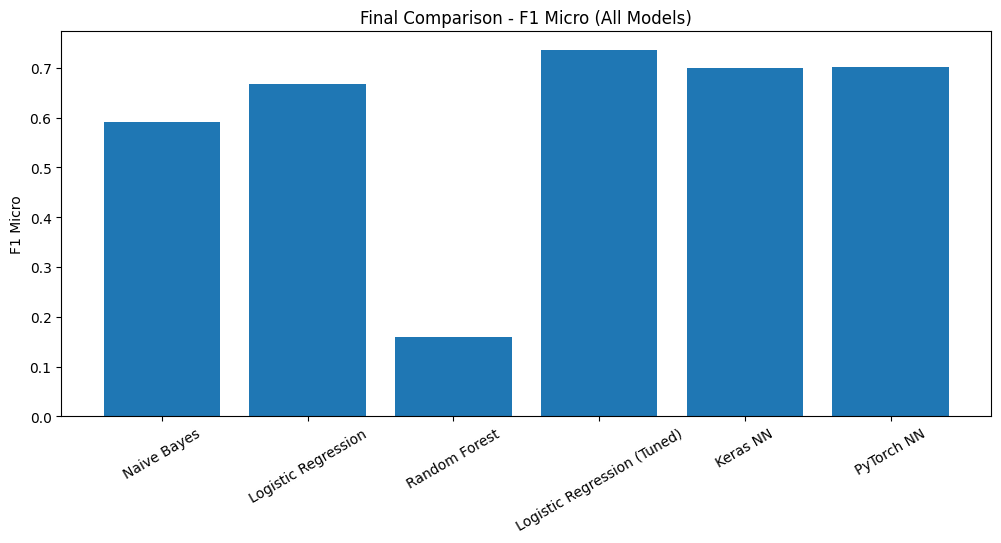

In [58]:
plt.figure(figsize=(12,5))
plt.bar(final_comparison["Model"], final_comparison["F1 Micro"])
plt.title("Final Comparison - F1 Micro (All Models)")
plt.ylabel("F1 Micro")
plt.xticks(rotation=30)
plt.show()
